# Periodic BCs

![image](../thumbnails/periodic_turbo.png)

This notebook sets up a rotationally periodic steady-state simulation of the [TU Berlin TurboLab Stator](https://www.caeses.com/wp-content/uploads/2016/07/TU_Berlin_Stator.pdf "TU berlin stator") using the Flow360 Python API. It focuses on applying **Periodic Boundary Conditions** using rotational periodicity solver settings.

## 1. Imports and Project Setup

We import the necessary Flow360 libraries and load the project geometry from the pre-existing volume mesh file provided by the `TutorialPeriodicBC` example module. The project is created directly from a pre generated volume mesh. The grid unit length is in millimeters (mm).

In [1]:
import flow360 as fl
from flow360.examples import TutorialPeriodicBC

# Fetch the necessary volume mesh file
TutorialPeriodicBC.get_files()

# Create the project from the pre-existing volume mesh
project = fl.Project.from_volume_mesh(
    TutorialPeriodicBC.mesh_filename,
    length_unit="mm",
    name="Tutorial Periodic Boundary Condition from Python",
)

# Get the volume mesh object to define surfaces for models
volume_mesh = project.volume_mesh

Output()

[12:27:44] INFO: VolumeMesh successfully submitted:                                                                
                   type        = Volume Mesh                                                                       
                   name        = Tutorial Periodic Boundary Condition from Python                                  
                   id          = vm-e82bc122-d82d-449a-9bab-23b3ec2fcff4                                           
                   status      = uploaded                                                                          
                   project id  = prj-6d073a5d-7cca-4517-b25d-59ca8ae66623                                          
           

Output()

--- 
## 2. Define the **operating_condition** simulation parameter

We define the operating condition based on Mach number and Reynolds number. All definitions are in the standard SI unit system with the Reynolds reference length being the grid unit (mm).

In [2]:
with fl.SI_unit_system:

    # Calculate full thermodynamic state from Mach and Reynolds numbers
    operating_condition = fl.AerospaceCondition.from_mach_reynolds(
        mach=0.13989,
        reynolds_mesh_unit=3200,
        project_length_unit=1 * fl.u.mm,
        temperature=298.25 * fl.u.K,
    )

[12:28:03] INFO: using: SI unit system for unit inference.

           INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

--- 
## 3. Define solver settings through the **Fluid** model

We define detailed settings for the steady-state Navier-Stokes and Spalart-Allmaras turbulence solvers, including absolute tolerances, linear solver limits, and 2nd order accuracy.

In [3]:
with fl.SI_unit_system:
    # Configure the Navier-Stokes solver for steady flow
    navier_stokes_solver = fl.NavierStokesSolver(
        absolute_tolerance=1e-11,
        linear_solver=fl.LinearSolver(max_iterations=20),
        order_of_accuracy=2,
        kappa_MUSCL=0.33,
        update_jacobian_frequency=1,
        equation_evaluation_frequency=1,
        numerical_dissipation_factor=1,
    )

    # Configure the Spalart-Allmaras turbulence model solver
    turbulence_model_solver = fl.SpalartAllmaras(
        absolute_tolerance=1e-10,
        linear_solver=fl.LinearSolver(max_iterations=20),
        update_jacobian_frequency=1,
        equation_evaluation_frequency=1,
        order_of_accuracy=2,
    )

    # Combine into a Fluid model
    fluid_model = fl.Fluid(
        navier_stokes_solver=navier_stokes_solver,
        turbulence_model_solver=turbulence_model_solver,
    )

           INFO: using: SI unit system for unit inference.

--- 
## 4. Define Boundary Condition Models

We assign boundary conditions to the surfaces defined in the volume mesh, including a crucial **Periodic** condition with rotational specification for the passage walls.

In [4]:
with fl.SI_unit_system:
    models_list = [
        fluid_model,
        # Wall surfaces (vane, blade fillet, shroud, hub)
        fl.Wall(
            surfaces=[
                volume_mesh["fluid/vane_*"],
                volume_mesh["fluid/bladeFillet_*"],
                volume_mesh["fluid/shroud"],
                volume_mesh["fluid/hub"],
            ]
        ),
        # Freestream inlet condition
        fl.Freestream(
            surfaces=[
                volume_mesh["fluid/inlet"],
            ]
        ),
        # Outflow condition with specified static pressure
        fl.Outflow(
            surfaces=[
                volume_mesh["fluid/outlet"],
            ],
            spec=fl.Pressure(
                1.0032 * operating_condition.thermal_state.pressure
            ),  # Slightly above ambient
        ),
        # Slip walls for computational domain boundaries (top/bottom)
        fl.SlipWall(
            surfaces=[
                volume_mesh["fluid/bottomFront"],
                volume_mesh["fluid/topFront"],
            ]
        ),
    ]

           INFO: using: SI unit system for unit inference.

# Define the **Periodic** Boundary Condition

The periodic boundary condition connects two sets of surfaces in the mesh that are opposite each other. We need to specify the two sets of faces and that the periodicity is rotational around the X-axis.

For more information on the **periodic** boundary conditions, refer to the [Flow360 User Guide](https://docs.flexcompute.com/projects/flow360/en/latest/python/api/_autosummary/flow360.Periodic.html#flow360.Periodic).

In [5]:
# Here we define the Periodic BC to connect the two periodic surfaces in the mesh.
models_list.append(
    # Rotational Periodic Boundary Condition
    fl.Periodic(
        surface_pairs=[
            (volume_mesh["fluid/periodic-1"], volume_mesh["fluid/periodic-2"])
        ],  # Connects the two radially oppose mesh surfaces
        spec=fl.Rotational(
            axis_of_rotation=(1, 0, 0)
        ),  # Specify rotation around X-axis
    ),
)

--- 
## 5. Define slice locations and outputs

We specify the desired slice locations and the output fields for volume data (**tecplot** format), surface data, and slice data. This ensures we capture all relevant flow physics for post-processing.

In [6]:
with fl.SI_unit_system:
    # Define slice planes for visualization and data extraction
    slice_inlet = fl.Slice(
        name="Inlet",
        normal=[1, 0, 0],
        origin=[-179, 0, 0] * fl.u.m,
    )
    slice_outlet = fl.Slice(
        name="Outlet",
        normal=[1, 0, 0],
        origin=[539, 0, 0] * fl.u.m,
    )
    slice_trailing_edge = fl.Slice(
        name="TrailingEdge",
        normal=[1, 0, 0],
        origin=[183, 0, 0] * fl.u.m,
    )
    slice_wake = fl.Slice(
        name="Wake",
        normal=[1, 0, 0],
        origin=[294.65, 0, 0] * fl.u.m,
    )
    outputs_list = [
        # Full Volume Output for 3D visualization (Tecplot recommended)
        fl.VolumeOutput(
            output_format="tecplot",
            output_fields=[
                "primitiveVars",
                "vorticity",
                "Cp",
                "Mach",
                "qcriterion",
                "mut",
                "nuHat",
                "mutRatio",
                "gradW",
                "T",
                "residualNavierStokes",
            ],
        ),
        # Surface Output for wall quantities
        fl.SurfaceOutput(
            surfaces=volume_mesh["*"],
            output_format="both",
            output_fields=[
                "primitiveVars",
                "Cp",
                "Cf",
                "CfVec",
                "yPlus",
                "nodeForcesPerUnitArea",
            ],
        ),
        # Slice Output for 2D flow field investigation
        fl.SliceOutput(
            slices=[slice_inlet, slice_outlet, slice_trailing_edge, slice_wake],
            output_format="both",
            output_fields=["Cp", "primitiveVars", "T", "Mach", "gradW"],
        ),
    ]

           INFO: using: SI unit system for unit inference.

--- 
## 6. Construct Final Simulation Parameters

We combine all the previously defined components—geometry, operating condition, time stepping (Steady), models, and outputs—into the final `SimulationParams` object.

In [7]:
with fl.SI_unit_system:
    params = fl.SimulationParams(
        reference_geometry=fl.ReferenceGeometry(
            moment_center=[0, 0, 0], moment_length=[1, 1, 1], area=209701.3096271187
        ),
        operating_condition=operating_condition,
        time_stepping=fl.Steady(max_steps=5000, CFL=fl.AdaptiveCFL()),
        models=models_list,
        outputs=outputs_list,
    )

           INFO: using: SI unit system for unit inference.

--- 
## 7. Run the Case 🏃

Finally, we submit the simulation using the configured parameters to Flow360.

In [8]:
case = project.run_case(
    params=params, name="Tutorial Periodic Boundary Condition from Python"
)

           INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

           INFO: using: SI unit system for unit inference.

[12:28:05] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = Tutorial Periodic Boundary Condition from Python                                  
                   id          = case-994ad1dc-1fc0-4e42-9d25-2e609778f2e8                                         
                   status      = pending                                                                           
                   project id  = prj-6d073a5d-7cca-4517-b25d-59ca8ae66623                                          
           

While we wait for the case to finish, we invite you to monitor the case in the Flow360 GUI. Once finished, you can easily post-process the results after completion.

Output()

Output()

[12:33:31] INFO: Saved to /tmp/tmpk0dinw1f/d01c7941-039c-4eda-bd68-fef55912ced2.csv

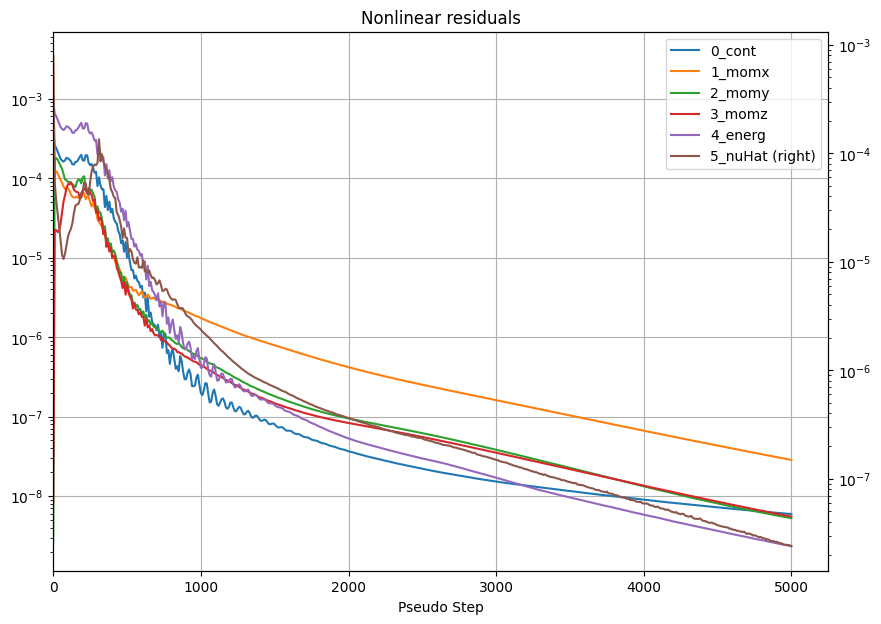

In [9]:
# wait until the case finishes execution
case.wait()

results = case.results

# nonlinear residuals contain convergence information
nonlinear_residuals = results.nonlinear_residuals.as_dataframe()
ax = nonlinear_residuals.plot(
    x="pseudo_step",
    y=["0_cont", "1_momx", "2_momy", "3_momz", "4_energ", "5_nuHat"],
    xlim=(0, None),
    xlabel="Pseudo Step",
    secondary_y=["5_nuHat"],
    figsize=(10, 7),
    logy=True,
    title="Nonlinear residuals",
)
ax.grid(True)